In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from random import sample

from IPython.core.debugger import set_trace


In [2]:
lr = 0.001
momentum = 0.9
num_epochs = 5
batch_size = 8
num_cls = 10

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./ds', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)

testset = torchvision.datasets.CIFAR10(root='./ds', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Files already downloaded and verified


# **TASK 1**. Classification task


## **Task 1.1** Define a standard convolutional network

In [4]:
class SimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_size)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

net = SimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

## **Task 1.2.** Training and evaluation

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train Loss: 1.7957, Train Acc: 0.3380, Val Loss: 1.4720, Val Acc: 0.4657
Epoch 2: Train Loss: 1.3822, Train Acc: 0.5010, Val Loss: 1.2907, Val Acc: 0.5400
Epoch 3: Train Loss: 1.2374, Train Acc: 0.5594, Val Loss: 1.1942, Val Acc: 0.5724
Epoch 4: Train Loss: 1.1298, Train Acc: 0.5990, Val Loss: 1.1113, Val Acc: 0.6058
Epoch 5: Train Loss: 1.0460, Train Acc: 0.6293, Val Loss: 1.0945, Val Acc: 0.6127


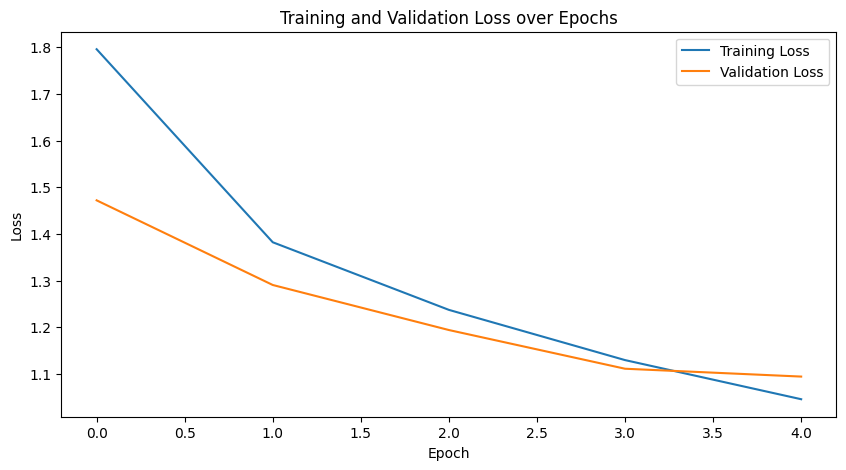

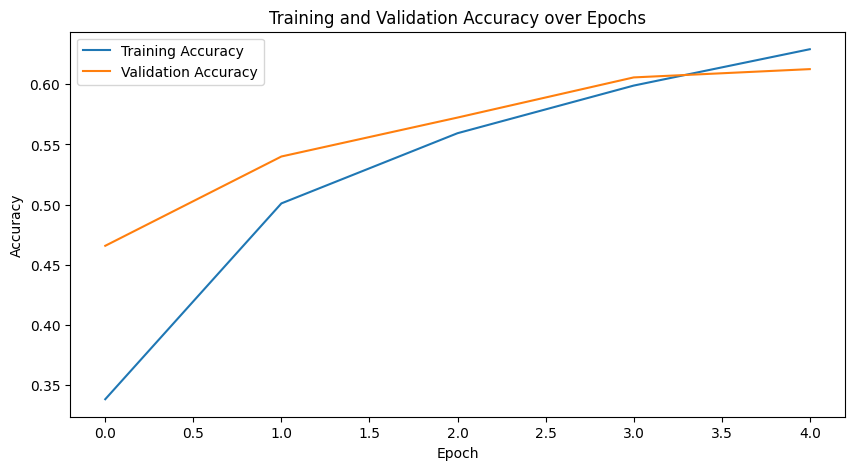

In [5]:
train_losses, val_losses = [], []
train_acc, val_acc = [], []

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    train_correct, train_total = 0, 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(trainloader))
    train_acc.append(train_correct / train_total)

    net.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_losses.append(val_running_loss / len(testloader))
    val_acc.append(val_correct / val_total)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_acc[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc[-1]:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## **Task 2.1.** Implement Linear layer



In [6]:
import math
import pdb
class myLinear(nn.Module):
  def __init__(self, in_features, out_features, device=None):
    super().__init__()
    self.in_features = in_features
    self.out_features = out_features
    # initialise parameters
    # weight shape: [in, out]
    # bias shape: [out]

    self.weight = torch.nn.parameter.Parameter(
        torch.empty(out_features, in_features)
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.empty(out_features)
    )

    self.reset_parameters()

  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_features)
    nn.init.uniform_(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):
    # weight shape: [out, in]
    # x shape: [batch, in]
    # we want do matrix multiplication between the weight and each element in the batch x[i] (seen as a column vector)
    # y[i] = W x[i]

    # in order to do this we rely on broadcasting in torch.matmul and must reshape x as [batch, in , 1]
    # such that the matrix multiplication is done on dimmensions [out, in] [in, 1] -> [out, 1]
    # (https://pytorch.org/docs/stable/generated/torch.matmul.html)

    # TODO
    # compute the linear operation using torch.matmul
    y = torch.matmul(self.weight, x.unsqueeze(-1))

    # we add the same bias column vector to each element in the batch y[i] = y[i] + bias
    # we rely again on broadcasting and make the bias have dimension [1, out, 1]
    # such that it aligns with y of shape [batch, out, 1]

    # TODO add bias
    y = y + self.bias.unsqueeze(-1)
    y = y.view(y.shape[0], -1)

    return y


In [7]:
linear = nn.Linear(8, 16)
my_linear = myLinear(8, 16)

my_linear.load_state_dict(linear.state_dict())
tensor = torch.rand(16, 8)

output_from_standard_layer = linear(tensor)
output_from_custom_layer = my_linear(tensor)

diff = torch.mean(torch.abs(output_from_standard_layer - output_from_custom_layer))

print("Mean absolute difference:", diff.item())

Mean absolute difference: 0.0


# **TASK 3.** Implement a convolutional layer

## **Task 3.1.** Implement Conv2d layer

In [8]:
class myConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size, device=None):
    super(myConv2d, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.kernel_size = kernel_size
    # initialise parameters
    scale = 1.0 / math.sqrt(in_channels * kernel_size * kernel_size)
    self.weight = torch.nn.parameter.Parameter(
        torch.rand(out_channels, in_channels, kernel_size, kernel_size)
    )
    self.bias = torch.nn.parameter.Parameter(
        torch.rand(out_channels)
    )

    self.reset_parameters()

  def reset_parameters(self):
    self.scale = 1.0 / math.sqrt(self.in_channels * self.kernel_size * self.kernel_size )
    nn.init.uniform_(self.weight, -self.scale, self.scale)
    nn.init.uniform_(self.bias, -self.scale, self.scale)

  def forward(self, x):

    # TODO

    batch_size, _, height, width = x.shape
    height_out = height - self.kernel_size + 1
    width_out = width - self.kernel_size + 1
    out = torch.zeros((batch_size, self.out_channels, height_out, width_out), device=x.device)

    for k in range(self.out_channels):
        for i in range(height_out):
            for j in range(width_out):
                for b in range(batch_size):
                    window = x[b, :, i:i+self.kernel_size, j:j+self.kernel_size]
                    out[b, k, i, j] = (self.weight[k] * window).sum() + self.bias[k]

    return out

In [9]:
standard_conv = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
custom_conv = myConv2d(in_channels=3, out_channels=8, kernel_size=5)

custom_conv.load_state_dict(standard_conv.state_dict())
tensor = torch.rand(10, 3, 32, 32)

output_from_standard_conv = standard_conv(tensor)
output_from_custom_conv = custom_conv(tensor)

diff = torch.mean(torch.abs(output_from_standard_conv - output_from_custom_conv))

print("Mean absolute difference:", diff.item())

Mean absolute difference: 3.2927250259717766e-08


## **Task 3.2.** Evaluate your implementation of convolutional network.

In [10]:
class mySimpleConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = myConv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.conv2 = myConv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = myLinear(16 * 5 * 5, 128)
        self.fc2 = myLinear(128, 64)
        self.fc3 = myLinear(64, out_size)


    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

my_net = mySimpleConvNet(out_size=num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
my_net = my_net.to(device)

In [11]:
import time
from tqdm import tqdm
from torch.utils.data import DataLoader


my_net.load_state_dict(net.state_dict())

def evaluate_model(model, loader, device):
    model.eval()
    total, correct = 0, 0
    start_time = time.time()

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            break # Process only the first batch

    end_time = time.time()
    accuracy = correct / total
    inference_time = end_time - start_time
    return accuracy, inference_time



smalltestloader_single_batch = DataLoader(testset, batch_size=20, shuffle=True)

accuracy_default, time_default = evaluate_model(net, smalltestloader_single_batch, device)
accuracy_custom, time_custom = evaluate_model(my_net, smalltestloader_single_batch, device)

print(f"\nDefault Network Accuracy: {accuracy_default:.2f}, Inference Time: {time_default:.4f} seconds")
print(f"Custom Network Accuracy: {accuracy_custom:.2f}, Inference Time: {time_custom:.4f} seconds")

time_ratio = time_custom / time_default
print(f"Time Ratio (Custom/Default): {time_ratio:.2f}")


Default Network Accuracy: 0.80, Inference Time: 0.0252 seconds
Custom Network Accuracy: 0.70, Inference Time: 9.1385 seconds
Time Ratio (Custom/Default): 363.01


## **Task 3.3.** Feature map visualization


In [12]:
class VisualConvNet(nn.Module):
    def __init__(self, out_size):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, out_size)
        self.activations = []

    def forward(self, x):
        self.activations = []
        x = self.conv1(x)
        self.activations.append(x)
        x = F.relu(self.pool(x))
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = F.relu(self.pool(x))
        self.activations.append(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def get_activations(self):
        return self.activations


model = VisualConvNet(num_cls)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

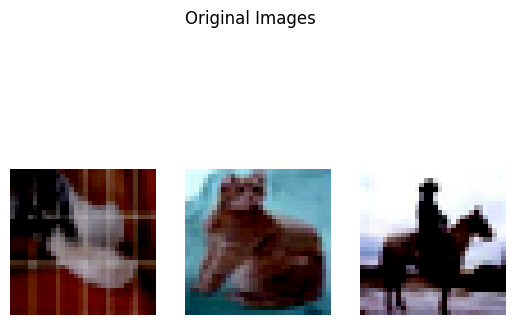

In [13]:
import matplotlib.pyplot as plt

images, _ = next(iter(trainloader))
images = images[:3]

fig, axs = plt.subplots(1, 3)
fig.suptitle('Original Images')
for i, img in enumerate(images):
    img = img.permute(1, 2, 0)
    axs[i].imshow(img)
    axs[i].axis('off')
plt.show()

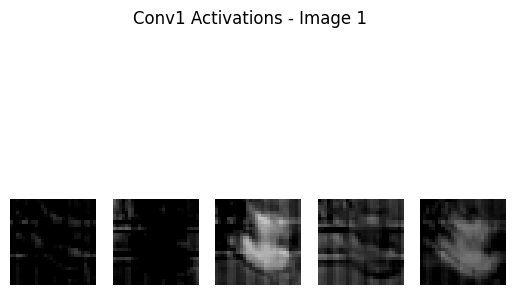

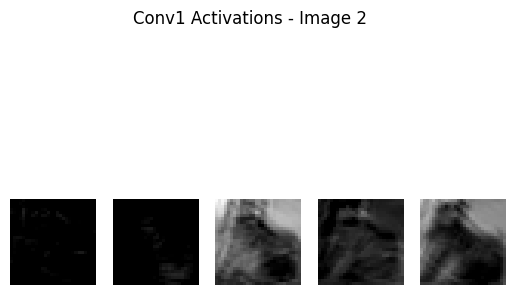

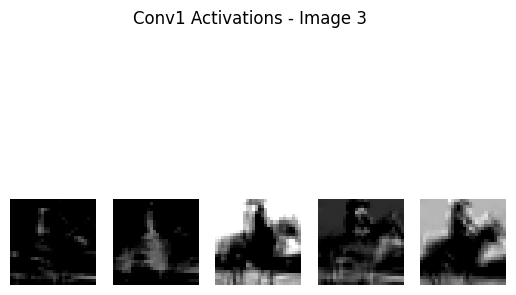

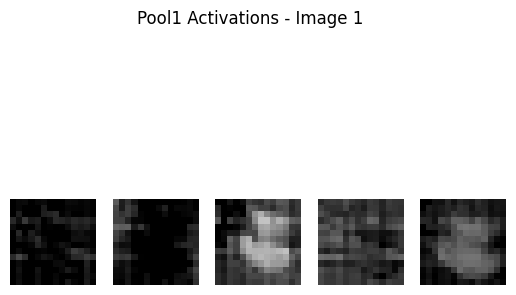

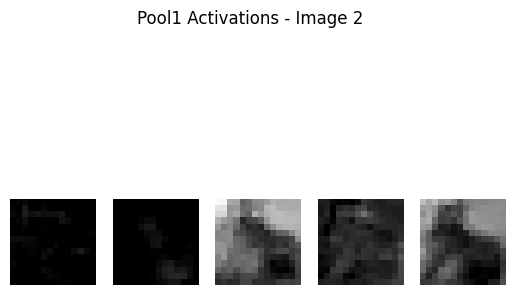

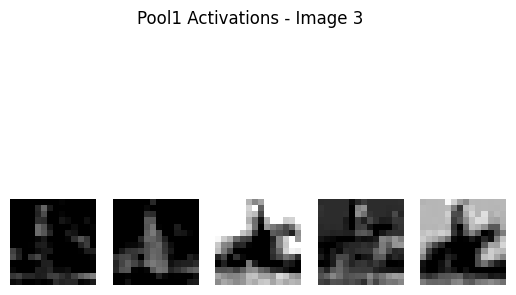

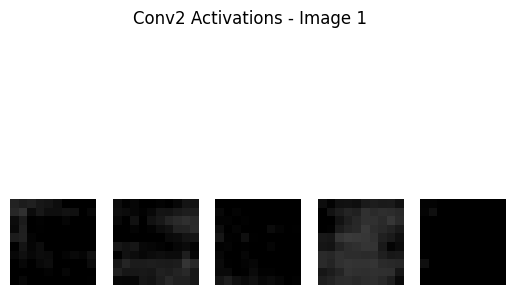

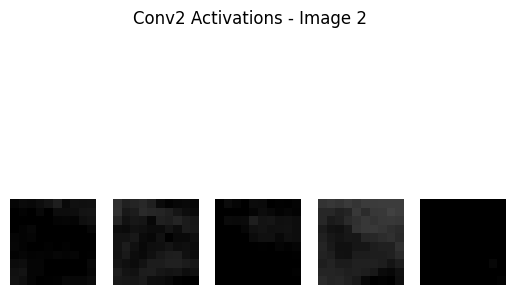

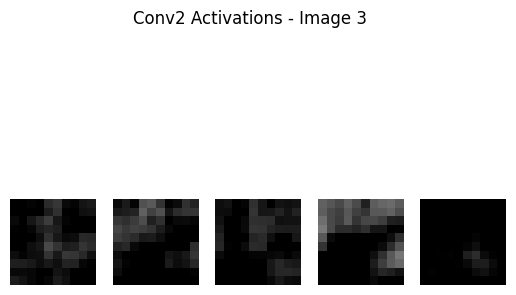

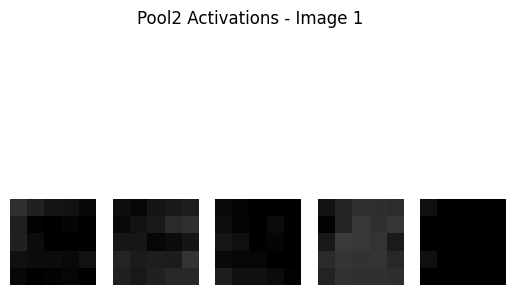

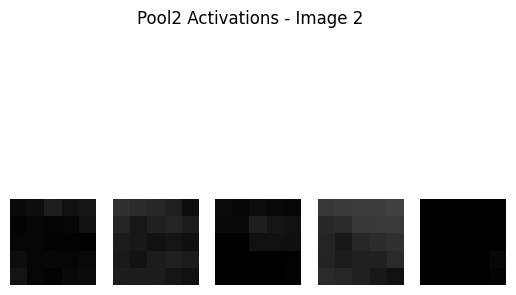

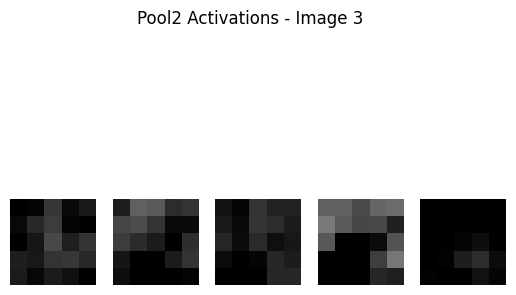

In [14]:
def feature_map_visualization(activations, layer_num):
    num_images = 3
    num_feature_maps = 5

    for i in range(num_images):
        fig, axarr = plt.subplots(1, num_feature_maps)
        fig.suptitle(f'{layer_name} Activations - Image {i+1}')

        for j in range(num_feature_maps):
            axarr[j].imshow(activations[i][j].detach().cpu().numpy(), cmap='gray', vmin=0, vmax=1)
            axarr[j].axis('off')
        plt.show()

model.eval()
with torch.no_grad():
    model(images)
    activation_list = model.get_activations()

layer_names = ['Conv1', 'Pool1', 'Conv2', 'Pool2']

for layer_name, activations in zip(layer_names, activation_list):
    feature_map_visualization(activations, layer_name)